In [1]:
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.decomposition import TruncatedSVD ,NMF
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import scattertext as st
from gensim import corpora, models, similarities, matutils
from collections import defaultdict
import csv

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,VotingClassifier, RandomForestRegressor , ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift , KMeans
from sklearn.preprocessing import StandardScaler
import scipy.sparse as ss
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
from collections import Counter
from spacy.symbols import amod
from pprint import pprint
import pandas as pd
import pickle
from nltk.tokenize import TreebankWordTokenizer
import json
from autocorrect import Speller
spell = Speller(lang='en')
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords 
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Loading Datasets
the datasets from Yelp in json format

In [3]:
data_file = open("../Dataset/yelp_academic_dataset_review.json")
data = []
for line in data_file:
    data.append(json.loads(line))
reviews_df = pd.DataFrame(data)
data_file.close()

In [4]:
data_file = open("../Dataset/yelp_academic_dataset_business.json")
data = []
for line in data_file:
    data.append(json.loads(line))
business_df = pd.DataFrame(data)
data_file.close()

In [5]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


In [6]:
reviews_df.shape

(8635403, 9)

In [7]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


In [8]:
business_df.shape

(160585, 14)

In [9]:
business_df_droped=business_df.drop(['address','postal_code','latitude','longitude','stars','is_open','hours','attributes'], axis=1)

In [13]:
dfall = pd.merge(reviews_df, business_df_droped)

In [14]:
#data we will use
data= dfall.sample(15000,random_state=199)

save the data using pickle


In [15]:
data.to_pickle("./data.pkl")

In [26]:
with open('data.pkl','rb') as read_file:
    data= pickle.load(read_file)

In [27]:
data.head()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,city,state,review_count,categories
7296028,3U32VpXkpWmdz4NH7HxIyw,mcNcCzHXvuLU-NgGaQtrUw,m3DAidF0Wu5OgDi95VIC6g,4.0,0,0,0,Let me start off by saying that I like how Pop...,2013-09-27 07:03:32,Poplandia Gourmet Popcorn,Portland,OR,54,"Food, Specialty Food"
845579,-0c1q-LLCr7wJkXGuqD_TQ,KQOPjOVAmJChdjg8v21sow,cTx4eOd6DSXS1eNOUD-qyQ,4.0,0,0,1,Simple menu with great pizza options! Thick cr...,2020-12-21 18:24:23,Pop Pizza,Portland,OR,43,"Restaurants, Pizza"
6327006,nWav1tfzJmUCMT5ZBTOTPA,BXIFpEq_PGsm7K-7EbMXZg,o_OXgvYNSgwaYiyZBeXWsw,5.0,0,0,0,I went last Saturday and was very pleased! Wh...,2010-01-13 15:30:46,West Side Lounge,Cambridge,MA,295,"Restaurants, Bars, American (Traditional), Nig..."
1365385,1hvtkibmVYjFqTYuX7MILg,doRSxMvROzyPoDIFGcqD8w,AjPE8KPBgefDuN81V6kPpQ,1.0,0,1,0,went there with friends recently and to be hon...,2009-12-19 01:19:40,Ledge Kitchen and Drinks,Boston,MA,161,"Restaurants, American (New)"
1518441,8-_RZUI0xOG8aH4Ulinx8g,T7rHrv3heIXRnHDGuW03Og,HHxrrOQWVi7iZjBJ0vgo-A,5.0,0,0,1,Great breakfast place. Friendly staff and gre...,2014-11-23 02:50:44,Java's,Natick,MA,39,"Food, Coffee & Tea, Restaurants, Sandwiches, B..."


## EDA
for first graph its shows Top 10 cities by businesses

In [28]:
city_business_counts = data[['city', 'business_id']].groupby(['city'])\
['business_id'].agg('count').sort_values(ascending=False)

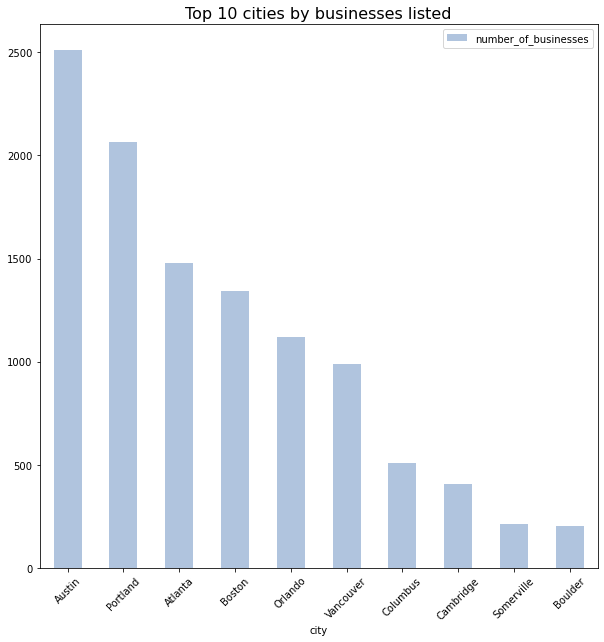

In [29]:
city_business_counts = pd.DataFrame(data=city_business_counts)
city_business_counts.rename(columns={'business_id' : 'number_of_businesses'}, inplace=True)

city_business_counts[0:10].sort_values(ascending=False, by="number_of_businesses")\
.plot(kind='bar', stacked=False, figsize=[10,10],color=['lightsteelblue'])
plt.title('Top 10 cities by businesses listed', fontsize=16)
plt.xticks(rotation=45);


In [30]:
city_business_reviews = data[['city', 'review_count', 'stars']].groupby(['city']).\
agg({'review_count': 'sum', 'stars': 'mean'}).sort_values(by='review_count', ascending=False)
city_business_reviews.head(10)

,review_count,stars
city,,
Portland,1219160,3.913843
Austin,1092830,3.844161
Boston,905523,3.660701
Atlanta,687024,3.657877
Orlando,436846,3.719392
Vancouver,216632,3.660931
Cambridge,169084,3.755501
Columbus,100562,3.783037
Somerville,71467,3.820755


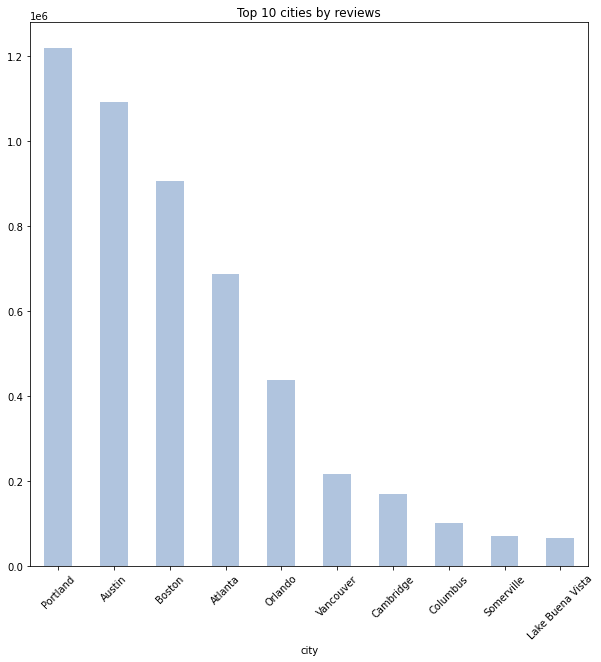

In [31]:
city_business_reviews['review_count'][0:10].plot(kind='bar', stacked=False, figsize=[10,10], \
                                                 color=['lightsteelblue'] )
plt.title('Top 10 cities by reviews')
plt.xticks(rotation=45);

for the above graph it shows which city has thhe most reviews



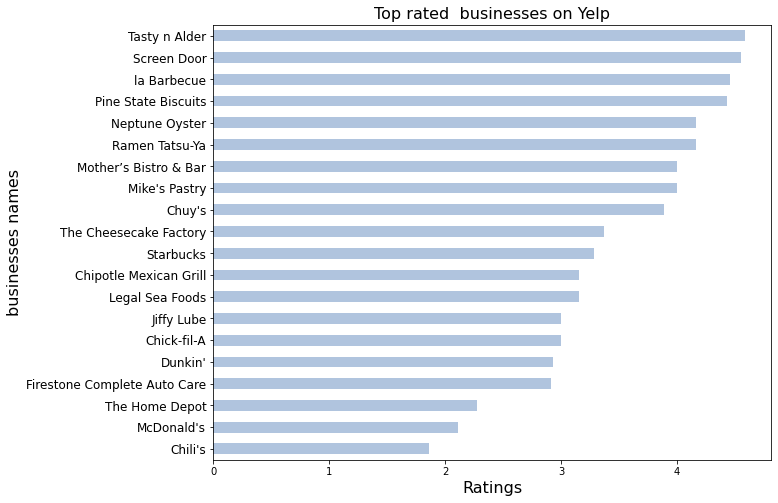

In [32]:
#inefficient if we take all of the business name

top_businesses = data.name.value_counts().index[:20].tolist()
df_review_top = data.loc[data['name'].isin(top_businesses)]
df_review_top.groupby(data.name)['stars'].mean().sort_values(ascending=True).plot(kind='barh',figsize=(10, 8), color=['lightsteelblue'])
plt.yticks(fontsize=12)
plt.title('Top rated  businesses on Yelp',fontsize=16)
plt.ylabel('businesses names', fontsize=16)
plt.xlabel('Ratings', fontsize=16)
plt.show()

this graph shows top 20 businesses by rating



## Data Cleaning


In [33]:
# make Sentiment only negative and positive , 1,2 for negarive  , 4,5 for positive
data = data[data.stars!=3]

data['Sentiment'] = np.where(data['stars'] >= 4, 'positive', 'negative')
data

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,city,state,review_count,categories,Sentiment
7296028,3U32VpXkpWmdz4NH7HxIyw,mcNcCzHXvuLU-NgGaQtrUw,m3DAidF0Wu5OgDi95VIC6g,4.0,0,0,0,Let me start off by saying that I like how Pop...,2013-09-27 07:03:32,Poplandia Gourmet Popcorn,Portland,OR,54,"Food, Specialty Food",positive
845579,-0c1q-LLCr7wJkXGuqD_TQ,KQOPjOVAmJChdjg8v21sow,cTx4eOd6DSXS1eNOUD-qyQ,4.0,0,0,1,Simple menu with great pizza options! Thick cr...,2020-12-21 18:24:23,Pop Pizza,Portland,OR,43,"Restaurants, Pizza",positive
6327006,nWav1tfzJmUCMT5ZBTOTPA,BXIFpEq_PGsm7K-7EbMXZg,o_OXgvYNSgwaYiyZBeXWsw,5.0,0,0,0,I went last Saturday and was very pleased! Wh...,2010-01-13 15:30:46,West Side Lounge,Cambridge,MA,295,"Restaurants, Bars, American (Traditional), Nig...",positive
1365385,1hvtkibmVYjFqTYuX7MILg,doRSxMvROzyPoDIFGcqD8w,AjPE8KPBgefDuN81V6kPpQ,1.0,0,1,0,went there with friends recently and to be hon...,2009-12-19 01:19:40,Ledge Kitchen and Drinks,Boston,MA,161,"Restaurants, American (New)",negative
1518441,8-_RZUI0xOG8aH4Ulinx8g,T7rHrv3heIXRnHDGuW03Og,HHxrrOQWVi7iZjBJ0vgo-A,5.0,0,0,1,Great breakfast place. Friendly staff and gre...,2014-11-23 02:50:44,Java's,Natick,MA,39,"Food, Coffee & Tea, Restaurants, Sandwiches, B...",positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6971039,3ebLuR34_WW2rMvClPUY9A,1kr9EZFV3T_l-8KBkfPo5Q,1qwxzGRcU1y3tJrsoYQ4Rw,4.0,0,0,0,Very nice beer and wine selection and the food...,2015-12-29 16:05:13,Picco Pizza & Ice Cream,Boston,MA,1186,"Restaurants, Bars, Nightlife, Pizza, Italian, ...",positive
988328,UsNuYHwW3oh-ohfYKcoWzQ,IuXXbHoJN9GpYh2CVfTtUg,Tr-8sVrdh9tfAsW7LaZ_Vg,4.0,0,0,0,"My first time being in Georgia, a little disap...",2013-09-29 16:47:38,Tin Lizzy's Cantina,Atlanta,GA,456,"Caterers, Bars, Mexican, Event Planning & Serv...",positive
8126127,SWO2wSRKSvcfxOvsRdu4hg,qN6rymMWE6BoyUEE88IvWg,wcLrRl8YbbrvnQk3K49udQ,4.0,0,0,0,Great find among the tourist traps and chains....,2011-04-04 03:21:41,Q'Kenan Restaurant,Orlando,FL,1074,"Restaurants, Breakfast & Brunch, Venezuelan, M...",positive
6202674,DPZbZCjoAnMDzvGVcUlA6A,vCb3gTId-wkeqPrOUMCqxA,sUGx4txCbV2muiOKwdzE2w,4.0,0,0,0,If you're looking for bar food and good drinks...,2015-07-21 22:06:39,The Porch,Winter Park,FL,679,"Chicken Wings, Nightlife, Restaurants, Burgers...",positive


In [34]:
# take only english words
data = data[data['text'].map(lambda x: x.isascii())]


In [35]:
# spell checking
data['text'] = data['text'].map(lambda x: spell(x))

In [36]:
# it takes long time so we save it in pickle
data.to_pickle("./data_after_spell.pkl")

In [37]:
with open('data_after_spell.pkl','rb') as read_file:
    data= pickle.load(read_file)

In [38]:
#check for alphanumeric , punctuation and repeated characteristics and remove thim
alphanumeric=lambda x: re.sub('\w*\d\w*','',x)
punc_lower=lambda x: re.sub('[%s]'%re.escape(string.punctuation),'',x.lower())

repeated_chars = lambda x: re.sub('(.)\1{2,}', '\1', x)


data['text']=data.text.map(alphanumeric).map(punc_lower).map(repeated_chars)

In [39]:
# cleaning function

ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):

    listofwords = sentence.strip().split()          # to remove any space from beginning and the end of text
    listof_words = []    
    for word in listofwords:
        if not word in ENGLISH_STOP_WORDS:
            lemm_word = WordNetLemmatizer().lemmatize(word)
            # remove the stop words
            for punctuation_mark in string.punctuation:
                word = word.replace(punctuation_mark, '')
            if len(word)>0:
                listof_words.append(word)
    return(listof_words)

In [40]:
cleaned_text = data.text

In [41]:
#adding costum stop words
stop_words = text.ENGLISH_STOP_WORDS.union(['didnt','havent', 'week', 'hi','wa','ha','day','today','really','also',
                                            'go', 'us', 'dont', 'got', 'im', 'ive','burger','food' ,'came', 'back',
                                           'get','try', 'would', 'time','good','great','service','large','order','les'
                                           ,'like','best','nice','love','pretty','extra', 'minutes','long','soft'
                                           ,'delicious', 'amazing','come','went','raven','definitely','friendly'
                                           ,'austin','boston','burgers','experience', 'people', 'better','make', 'favorite'
                                            , 'price','going','place','think','room','wait','way','know'
                                           ,'say','right','wanted','wasnt','took','told','left','asked','said'
                                           ,'small','little','want','youre','lot','big','quite','probably','maybe'
                                            ,'bit','novella','flip','tried','thierry','ordered','pho','sure'
                                           ,'help', 'awesome', 'excellent', 'perfect','recommend','risky','vancouver'
                                            ,'wonderful', 'use', 'used','willamette','bad','actually','things','isip'
                                            ,'spring', 'usually', 'new','fast','run','moving','getting', 'taking','hotel'
                                           ,'thats','thing','away','eat','looked','times','need','fact','thought'
                                            ,'look','doesnt','isnt','yes','walk','finally','let','waiting','walked','tell'
                                            ,'gave','check','later','feel','id','trying','oh','kind','looking','star','comes'
                                            ,'old','theres','different','home','ill','high','theyre','hard','mind',
                                            'mean','years', 'pay', 'money','called','pad','needed'
                                            ,'actresses','similar','relatively','pleasant','ow','opinion','impressed',
                                            'husbands','aside','wanting','unlike','treats','strange','st','sort','smooth'])

In [42]:
# define TF-IDF vectorizer
Tf_vectorizer = TfidfVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words = stop_words).fit(cleaned_text)
text_tf = Tf_vectorizer.transform(cleaned_text)

In [43]:
# define Count vectorizer
C_vectorizer = CountVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words= stop_words ).fit(cleaned_text)
text_cv = C_vectorizer.transform(cleaned_text)